<a href="https://colab.research.google.com/github/JoGyeongDeok/Project/blob/main/Dacon/2022_9_16_Samsung_AI_Challenge_(3D_Metrology).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Samsung AI Challenge (3D Metrology)
***https://dacon.io/competitions/official/235954/overview/description***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
CFG = {
    'WIDTH':48,
    'HEIGHT':72,
    'EPOCHS':60,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':64,
    'SEED':41
}

path= '/content/drive/MyDrive/DACON/Data/2022 Samsung AI Challenge (3D Metrology)'

import zipfile
zipfile.ZipFile(path+'.zip','r').extractall('/2022 Samsung AI Challenge (3D Metrology)')

# Library

In [ ]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import glob
import cv2
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import autograd

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings(action='ignore') 

from torch.autograd._functions import Resize

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [ ]:
# def get_key(path):
#     names = path.split("/")
#     return f"{names[-3].lower()}_{names[-2]}"

# df_depth = pd.read_csv("/2022 Samsung AI Challenge (3D Metrology)/train/average_depth.csv")
# table = {k: v for k, v in zip(df_depth["0"].values, df_depth["1"].values)}

# files = glob.glob("/2022 Samsung AI Challenge (3D Metrology)/train/SEM/*/*/*.png")
# depth = [table[get_key(file)] for file in files]

# df_out = pd.DataFrame()
# df_out["path"] = files
# df_out["depth"] = depth

In [ ]:
simulation_sem_paths = sorted(glob.glob('/2022 Samsung AI Challenge (3D Metrology)/simulation_data/SEM/*/*/*.png'))
simulation_depth_paths = sorted(glob.glob('/2022 Samsung AI Challenge (3D Metrology)/simulation_data/Depth/*/*/*.png')+glob.glob('/2022 Samsung AI Challenge (3D Metrology)/simulation_data/Depth/*/*/*.png'))
test_sem_path_list = sorted(glob.glob('/2022 Samsung AI Challenge (3D Metrology)/test/SEM/*.png'))



In [ ]:
data_len = len(simulation_sem_paths) # == len(simulation_depth_paths)

In [ ]:
print(len(simulation_sem_paths))
print(len(simulation_depth_paths))

173304
173304


In [ ]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])

#Edge

In [ ]:
depth_110 = sorted(glob.glob('/2022 Samsung AI Challenge (3D Metrology)/train/SEM/Depth_110/*/*'))
depth_120 = sorted(glob.glob('/2022 Samsung AI Challenge (3D Metrology)/train/SEM/Depth_120/*/*'))
depth_130 = sorted(glob.glob('/2022 Samsung AI Challenge (3D Metrology)/train/SEM/Depth_130/*/*'))
depth_140 = sorted(glob.glob('/2022 Samsung AI Challenge (3D Metrology)/train/SEM/Depth_140/*/*'))#

In [ ]:
train_SEM_images = depth_110 + depth_120 + depth_130 + depth_140
depth_label = np.concatenate([np.repeat(0, len(depth_110)), np.repeat(1, len(depth_120)), 
                        np.repeat(2, len(depth_130)), np.repeat(3, len(depth_140))])

In [ ]:
class CustomDataset3(Dataset):
    def __init__(self, sem_path_list, depth, transform):
        self.sem_path_list = sem_path_list
        self.depth = depth
        self.transform = transform

    def __len__(self):
        return len(self.sem_path_list)

    def __getitem__(self, idx):
        sem_path = self.sem_path_list[idx]

        sem_img = cv2.imread(sem_path, cv2.IMREAD_COLOR)
        sem_img = self.transform(sem_img)


        sem_img = sem_img / 255.
        
        if self.depth is not None:
            depth_label = self.depth[idx]
            return sem_img, depth_label

        else:
            return sem_img

In [ ]:
train_idx , valid_idx = train_test_split(range(len(train_SEM_images)), test_size = 0.2, random_state = 42)

train_sem_paths = np.array(train_SEM_images)[train_idx]
train_depth = np.array(depth_label)[train_idx]

valid_sem_paths = np.array(train_SEM_images)[valid_idx]
valid_depth = np.array(depth_label)[valid_idx]

In [ ]:
train_dataset = CustomDataset3(train_sem_paths, train_depth, train_transform)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True)

valid_dataset = CustomDataset3(valid_sem_paths, valid_depth, train_transform)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

test_dataset = CustomDataset3(test_sem_path_list, None, train_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
category_model = models.resnet101(pretrained=False).to(device)  # 모델 객체 생성
category_model.fc = torch.nn.Linear(2048, 4)
category_model = category_model.to(device)
optimizer = torch.optim.SGD(category_model.parameters(), lr = 0.005, momentum = 0.9)

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Loss Function
criterion = nn.CrossEntropyLoss().to(device)
best_score = 0

for epoch in range(1,100+1):
    category_model.train()
    train_loss = []
    vali_accuracy = []
    true = []
    pred = []
    for img, label in tqdm(iter(train_loader)):
        img, label = img.float().to(device),label.to(device)
        optimizer.zero_grad()
        logit = category_model(img)

        loss = criterion(logit, label)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    category_model.eval() # Evaluation
    vali_loss = []
    with torch.no_grad():
        for img,  label in tqdm(iter(valid_loader)):
            img,  label = img.float().to(device), label.to(device)

            logit = category_model(img)

            loss = criterion(logit, label)

            vali_loss.append(loss.item())
            true.extend(list(label.to('cpu').detach().numpy()))
            pred.extend(list(torch.argmax(logit, 1).to('cpu').detach().numpy()))
    vali_accuracy = accuracy_score(true, pred) 
    vali_mae_loss = np.mean(vali_loss)
    if vali_accuracy > best_score:
        print('모델 갱신')
        best_score = vali_accuracy
        best_model = category_model

    print(f'Epoch [{epoch}] Train CrossEntroy : [{np.mean(train_loss):.5f}] Validation CrossEntroy : [{vali_mae_loss:.5f}] Validation acc : [{vali_accuracy:.5f}] \n')


In [ ]:
best_model.eval()
test_edge = []

with torch.no_grad():
    for img in tqdm(iter(test_loader)):
        img = img.float().to(device)
        optimizer.zero_grad()
        logit = torch.argmax(best_model(img), 1)
        test_edge += list(logit.to('cpu').detach().numpy())

  0%|          | 0/204 [00:00<?, ?it/s]

# Custom

In [ ]:
train_idx , valid_idx = train_test_split(range(len(simulation_sem_paths)), test_size = 0.2, random_state = 42)

train_sem_paths = np.array(simulation_sem_paths)[train_idx]
train_depth_paths = np.array(simulation_depth_paths)[train_idx]

val_sem_paths = np.array(simulation_sem_paths)[valid_idx]
val_depth_paths = np.array(simulation_depth_paths)[valid_idx]

test_sem_path_list = sorted(glob.glob('/2022 Samsung AI Challenge (3D Metrology)/test/SEM/*.png'))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sem_path_list, depth_path_list, transform, id = None):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        self.transform = transform
        self.id = id

    def __len__(self):
        return len(self.sem_path_list)


    def __getitem__(self, index):
        sem_path = self.sem_path_list[index]
        # sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)
        # sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)

        
        # VAE
        sem_img = cv2.imread(sem_path, cv2.IMREAD_COLOR)

        if self.depth_path_list is not None:
            sem_img = cv2.GaussianBlur(sem_img, (0, 0), 0.55)    
            if 'Case_1' in sem_path:
                ed = 140
            elif 'Case_2' in sem_path:
                ed = 150
            elif 'Case_3' in sem_path:
                ed = 160
            else:
                ed = 170
        else:
            if self.id[index] == 0:
                ed = 140
            elif self.id[index] == 1:
                ed = 150
            elif self.id[index] == 2:
                ed = 160
            else:
                ed = 170
        ed = ed / 255.

        sem_img = sem_img / 255.
        if self.transform is not None:
            sem_img = self.transform(sem_img)
        

        if self.depth_path_list is not None:
            depth_path = self.depth_path_list[index]
            # depth_img = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
            # depth_img = np.expand_dims(depth_img, axis=-1).transpose(2,0,1)

            # VAE
            depth_img = cv2.imread(depth_path, cv2.IMREAD_COLOR)
            depth_img = depth_img / 255.

            return sem_img, depth_img, ed
        else:
            img_name = sem_path.split('/')[-1]
            return sem_img, img_name , ed # B,C,H,W

In [ ]:
train_dataset = CustomDataset(train_sem_paths, train_depth_paths, transform = train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

val_dataset = CustomDataset(val_sem_paths, val_depth_paths, transform = train_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

test_dataset = CustomDataset(test_sem_path_list, None, transform = train_transform, id = test_edge)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

# 평균 Depth 예측

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
le.fit(df_out.depth)
df_out.depth = le.transform(df_out.depth)

In [ ]:
class CustomDataset2(Dataset):
    def __init__(self, sem_path_list, depth, transform):
        self.sem_path_list = sem_path_list
        self.depth = depth
        self.transform = transform

    def __len__(self):
        return len(self.sem_path_list)

    def __getitem__(self, idx):
        sem_path = self.sem_path_list[idx]

        sem_img = cv2.imread(sem_path, cv2.IMREAD_COLOR)
        sem_img = self.transform(sem_img)


        sem_img = sem_img / 255.
        
        if self.depth is not None:
            mean_depth = self.depth[idx]
            return sem_img, mean_depth

        else:
            return sem_img

In [ ]:
train_idx , valid_idx = train_test_split(range(df_out.shape[0]), test_size = 0.2, random_state = 42)

train_sem_paths = np.array(df_out.iloc[train_idx, 0])
train_depth = np.array(df_out.iloc[train_idx, 1])

valid_sem_paths = np.array(df_out.iloc[valid_idx, 0])
valid_depth = np.array(df_out.iloc[valid_idx, 1])

In [ ]:
train_dataset = CustomDataset2(train_sem_paths, train_depth, train_transform)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True)

valid_dataset = CustomDataset2(valid_sem_paths, valid_depth, train_transform)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

test_dataset = CustomDataset2(test_sem_path_list, None, train_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
category_model = models.resnet101(pretrained=False)  # 모델 객체 생성
category_model.fc = torch.nn.Linear(2048, len(df_out.depth.unique()))
category_model = category_model.to(device)
optimizer = torch.optim.SGD(category_model.parameters(), lr = 0.001, momentum = 0.9)


# total_iter = len(train_loader)
# warmup_iter = 100

# scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, total_iter-warmup_iter)
# scheduler = LearningRateWarmUP(optimizer=optimizer,
#                                    warmup_iteration=warmup_iter,
#                                    target_lr=0.001,
#                                    after_scheduler=scheduler_cosine)


In [ ]:
train(category_model, optimizer, train_loader, valid_loader, None, device, 2)

In [ ]:
test_depth_mean = np.array([])
with torch.no_grad():
    for sem in tqdm(test_loader):
        sem = sem.float().to(device)
        
        pred = F.softmax(category_model(sem))
        model_pred = torch.sum(pred * 
                                torch.tensor(le.classes_).to(device), axis = 1)
        test_depth_mean = np.append(test_depth_mean, model_pred.to('cpu').detach().numpy())

  0%|          | 0/204 [00:00<?, ?it/s]

# 실험

In [ ]:
train_depth_mean = []
train_sem_mean = []
for i in range(df_out.shape[0]):
    train_depth_mean.append(df_out.iloc[i, 1])
    train_sem_mean.append(np.mean(cv2.imread(df_out.iloc[i, 0])))

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(np.array(train_depth_mean).reshape(-1, 1), np.array(train_sem_mean).reshape(-1, 1))

LinearRegression()

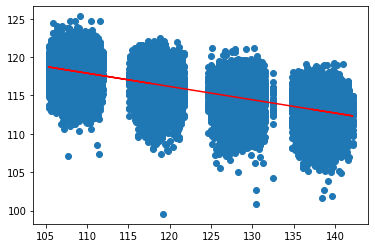

In [ ]:
import matplotlib.pyplot as plt
y_pred = lr.predict(np.array(train_depth_mean).reshape(-1, 1))
plt.scatter(train_depth_mean, train_sem_mean)
plt.plot(np.array(train_depth_mean), y_pred, color = 'red')

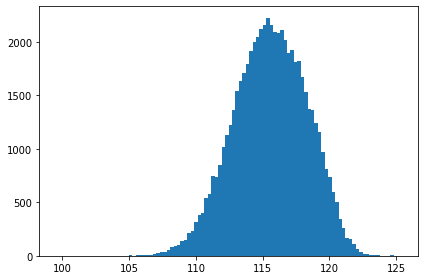

In [ ]:
plt.hist(train_sem_mean, bins=100)
plt.tight_layout()
plt.show()

In [ ]:
simul_depth_mean = []
for i in simulation_depth_paths:
    simul_depth_mean.append(np.mean(cv2.imread(i)))

13.53441007426757


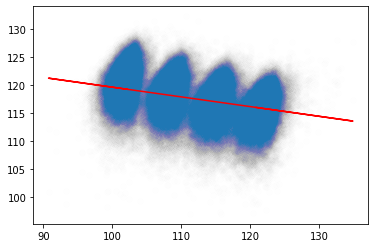

In [ ]:
kernel = np.array([[2, 1], 
            [2.9, 3.5]])
k = kernel / 8

simul_sem_mean = []
for i in simulation_sem_paths:
    img = cv2.imread(i)

    img = cv2.filter2D(img, ddepth = -1, kernel = k)
    
    simul_sem_mean.append(np.mean(img))

y_pred = lr.predict(np.array(simul_depth_mean).reshape(-1, 1))

plt.scatter(simul_depth_mean, simul_sem_mean, alpha = 0.005)
plt.plot(simul_depth_mean, y_pred, color = 'red')
mse = mean_squared_error(simul_sem_mean, y_pred)
print(mse)

In [ ]:
13.53441007426757

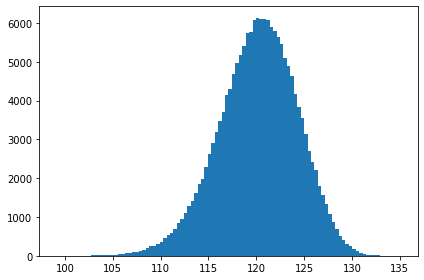

In [ ]:
plt.hist(simul_sem_mean, bins=100)
plt.tight_layout()
plt.show()

In [ ]:
simul_sem_mean_scale = abs((simul_sem_mean-np.mean(simul_sem_mean))/np.std(simul_sem_mean))
drop_idx = np.where(simul_sem_mean_scale > 1.96)[0]


In [ ]:
new_simulation_sem_paths = np.array(simulation_sem_paths)[list(drop_idx)]
new_simulation_depth_paths = np.array(simulation_depth_paths)[list(drop_idx)]

In [ ]:
simul_depth_mean = []
for i in new_simulation_depth_paths:
    simul_depth_mean.append(np.mean(cv2.imread(i)))

69.32920496702975


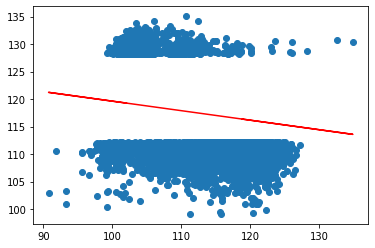

In [ ]:
kernel = np.array([[2, 1], 
            [3.1, 3.5]])
k = kernel / 8

simul_sem_mean = []
for i in new_simulation_sem_paths:
    img = cv2.imread(i)

    img = cv2.filter2D(img, ddepth = -1, kernel = k)
    
    simul_sem_mean.append(np.mean(img))

y_pred = lr.predict(np.array(simul_depth_mean).reshape(-1, 1))

plt.scatter(simul_depth_mean, simul_sem_mean)
plt.plot(simul_depth_mean, y_pred, color = 'red')
mse = mean_squared_error(simul_sem_mean, y_pred)
print(mse)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


In [ ]:
def get_key(path):
    path = os.path.normpath(path)
    names = path.split(os.sep)
    return f"{names[-3].lower()}_{names[-2]}"

In [ ]:
def get_mean(path):
    return np.mean(cv2.imread(path, 0))

In [ ]:
path = '/2022 Samsung AI Challenge (3D Metrology)'

# train sem image mean
test_a = os.path.join(path, "test", "SEM", "*.png")
test_a = glob.glob(test_a)
test_a = [get_mean(pa) for pa in test_a]

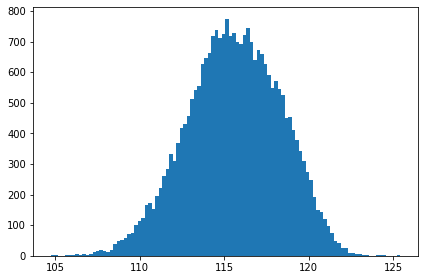

In [ ]:
# graph

plt.hist(test_a, bins=100)


plt.tight_layout()
plt.show()

In [ ]:
# train sem image mean
train_110 = os.path.join(path, "train", "SEM", "Depth_110", "*/*.png")
train_110 = glob.glob(train_110)
train_110 = [get_mean(pa) for pa in train_110]

train_120 = os.path.join(path, "train", "SEM", "Depth_120", "*/*.png")
train_120 = glob.glob(train_120)
train_120 = [get_mean(pa) for pa in train_120]

train_130 = os.path.join(path, "train", "SEM", "Depth_130", "*/*.png")
train_130 = glob.glob(train_130)
train_130 = [get_mean(pa) for pa in train_130]

train_140 = os.path.join(path, "train", "SEM", "Depth_140", "*/*.png")
train_140 = glob.glob(train_140)
train_140 = [get_mean(pa) for pa in train_140]

# train depth
df_depth = pd.read_csv("/2022 Samsung AI Challenge (3D Metrology)/train/average_depth.csv")
table = {k: v for k, v in zip(df_depth["0"].values, df_depth["1"].values)}

files = glob.glob("/2022 Samsung AI Challenge (3D Metrology)/train/SEM/Depth_110/*/*.png")
depth_train_110 = [table[get_key(file)] for file in files]

files = glob.glob("/2022 Samsung AI Challenge (3D Metrology)/train/SEM/Depth_120/*/*.png")
depth_train_120 = [table[get_key(file)] for file in files]

files = glob.glob("/2022 Samsung AI Challenge (3D Metrology)/train/SEM/Depth_130/*/*.png")
depth_train_130 = [table[get_key(file)] for file in files]

files = glob.glob("/2022 Samsung AI Challenge (3D Metrology)/train/SEM/Depth_140/*/*.png")
depth_train_140 = [table[get_key(file)] for file in files]


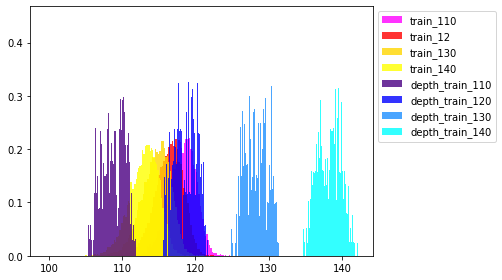

In [ ]:
# graph

plt.figure(figsize=(12, 4))

plt.hist(train_110, bins=100, density=True, alpha=0.8, label="train_110", color="#FF00FF")
plt.hist(train_120, bins=100, density=True, alpha=0.8, label="train_12", color="#FF0000")
plt.hist(train_130, bins=100, density=True, alpha=0.8, label="train_130", color="#FFD700")
plt.hist(train_140, bins=100, density=True, alpha=0.8, label="train_140", color="#FFFF00")
plt.hist(depth_train_110, bins=100, density=True, alpha=0.8, label="depth_train_110", color="#4B0082")
plt.hist(depth_train_120, bins=100, density=True, alpha=0.8, label="depth_train_120", color="#0000FF")
plt.hist(depth_train_130, bins=100, density=True, alpha=0.8, label="depth_train_130", color="#1E90FF")
plt.hist(depth_train_140, bins=100, density=True, alpha=0.8, label="depth_train_140", color="#00FFFF")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1.0))

plt.tight_layout()
plt.show()

In [ ]:
# simulation sem image mean
simul_case_1 = os.path.join(path, "simulation_data", "SEM", "Case_1", "*/*.png")
simul_case_1 = glob.glob(simul_case_1)
simul_case_1 = [get_mean(pa) for pa in simul_case_1]

simul_case_2 = os.path.join(path, "simulation_data", "SEM", "Case_2", "*/*.png")
simul_case_2 = glob.glob(simul_case_2)
simul_case_2 = [get_mean(pa) for pa in simul_case_2]

simul_case_3 = os.path.join(path, "simulation_data", "SEM", "Case_3", "*/*.png")
simul_case_3 = glob.glob(simul_case_3)
simul_case_3 = [get_mean(pa) for pa in simul_case_3]

simul_case_4 = os.path.join(path, "simulation_data", "SEM", "Case_4", "*/*.png")
simul_case_4 = glob.glob(simul_case_4)
simul_case_4 = [get_mean(pa) for pa in simul_case_4]

# simulation depth image mean
depth_simul_case_1 = os.path.join(path, "simulation_data", "Depth", "Case_1", "*/*.png")
depth_simul_case_1 = glob.glob(depth_simul_case_1)
depth_simul_case_1 = [get_mean(pa) for pa in depth_simul_case_1]

depth_simul_case_2 = os.path.join(path, "simulation_data", "Depth", "Case_2", "*/*.png")
depth_simul_case_2 = glob.glob(depth_simul_case_2)
depth_simul_case_2 = [get_mean(pa) for pa in depth_simul_case_2]

depth_simul_case_3 = os.path.join(path, "simulation_data", "Depth", "Case_3", "*/*.png")
depth_simul_case_3 = glob.glob(depth_simul_case_3)
depth_simul_case_3 = [get_mean(pa) for pa in depth_simul_case_3]

depth_simul_case_4 = os.path.join(path, "simulation_data", "Depth", "Case_4", "*/*.png")
depth_simul_case_4 = glob.glob(depth_simul_case_4)
depth_simul_case_4 = [get_mean(pa) for pa in depth_simul_case_4]

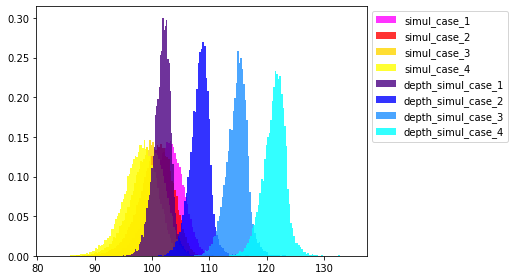

In [ ]:
# graph

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(simul_case_1, bins=100, density=True, alpha=0.8, label="simul_case_1", color="#FF00FF")
plt.hist(simul_case_2, bins=100, density=True, alpha=0.8, label="simul_case_2", color="#FF0000")
plt.hist(simul_case_3, bins=100, density=True, alpha=0.8, label="simul_case_3", color="#FFD700")
plt.hist(simul_case_4, bins=100, density=True, alpha=0.8, label="simul_case_4", color="#FFFF00")
plt.hist(depth_simul_case_1, bins=100, density=True, alpha=0.8, label="depth_simul_case_1", color="#4B0082")
plt.hist(depth_simul_case_2, bins=100, density=True, alpha=0.8, label="depth_simul_case_2", color="#0000FF")
plt.hist(depth_simul_case_3, bins=100, density=True, alpha=0.8, label="depth_simul_case_3", color="#1E90FF")
plt.hist(depth_simul_case_4, bins=100, density=True, alpha=0.8, label="depth_simul_case_4", color="#00FFFF")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1.0))

plt.tight_layout()
plt.show()

In [ ]:
# train sem image mean
depth_simul_case_4 = os.path.join(path, "simulation_data", "Depth", "Case_4", "*/*.png")
depth_simul_case_4 = glob.glob(depth_simul_case_4)

import random 
for i in random.sample(depth_simul_case_4, 10):
    plt.hist(cv2.imread(i).reshape(-1))
    plt.show()

In [ ]:
import random 
for i in random.sample(train_110, 10):
    plt.hist(cv2.imread(i).reshape(-1))
    plt.show()

In [ ]:
img = cv2.imread(simulation_sem_paths[0])

kernel = np.array([[1, 1], 
                [1, 1]])
k = kernel / 4

img_2 = cv2.filter2D(img, 0, k)

print(np.mean(img))
print(np.mean(img_2))

100.92621527777777
101.16811342592592


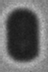

In [ ]:
cv2_imshow(img_2)

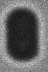

In [ ]:
cv2_imshow(img)

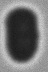

In [ ]:
cv2_imshow(cv2.imread(df_out.path[0]))

In [ ]:
np.mean(cv2.imread(simulation_sem_paths[0]))

In [ ]:
simulation_depth_paths[0]

'/2022 Samsung AI Challenge (3D Metrology)/simulation_data/Depth/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3.png'

# VAE

In [ ]:
# https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed

In [ ]:
%%capture
!pip install pytorch-lightning
!pip install pytorch-lightning-bolts

In [ ]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import resnet50_decoder, resnet50_encoder, resnet18_decoder, resnet18_encoder

In [ ]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=CFG['BATCH_SIZE'], input_height=CFG['HEIGHT']):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)


        self.Linear1 = nn.Sequential(
            nn.Linear(CFG['HEIGHT']*CFG['HEIGHT'], CFG['HEIGHT']*CFG['WIDTH']),
        )


    def forward(self, x, ed):

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), F.sigmoid(self.fc_var(x_encoded))



        # sample z from q
        std = torch.exp(log_var / 2) 
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = self.decoder(z)
        x_hat = x_hat.view( -1, CFG['HEIGHT']*CFG['HEIGHT'])
        x_hat = self.Linear1(x_hat)
        x_hat = x_hat.view(-1, CFG['HEIGHT'], CFG['WIDTH'], 3)
        for i in range(x_hat.shape[0]):
            x_hat[i][x_hat[i] > ed[i]] = ed[i]
            

        return x_hat

# Base Model

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(CFG['HEIGHT']*CFG['WIDTH'], 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(), 
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, CFG['HEIGHT']*CFG['WIDTH']),
        )
        
    def forward(self, x):
        x = x.view(-1, CFG['HEIGHT']*CFG['WIDTH'])
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, CFG['HEIGHT'], CFG['WIDTH'])
        return x

# 학습

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device, model_num = None):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    best_score = 999999
    best_model = None
    
    for epoch in range(1, 101):
        print(optimizer.state_dict)
        
        model.train()
        train_loss = []
        cnt = 0
        for sem, depth, ed in tqdm(train_loader):

            cnt += 1
            sem = sem.float().to(device)
            depth = depth.float().to(device)
            ed = ed.float().to(device)
            
            optimizer.zero_grad()            
            model_pred = model(sem, ed) 

            loss = criterion(model_pred, depth)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(np.sqrt(loss.item()))
            if cnt % 200 == 0:
                print("train loss", np.mean(train_loss))
        if scheduler is not None:
            scheduler.step(1)      
            
        val_loss, val_rmse = validation(model, criterion, val_loader, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val RMSE : [{val_rmse:.5f}]')
        
        if best_score > val_rmse:
            best_score = val_rmse
            best_model = model
            torch.save(model.state_dict(), PATH)

        inference(model, test_loader, device, epoch)
        

    return best_model

In [ ]:
def validation(model, criterion, val_loader, device):
    model.eval()
    mse = nn.MSELoss().to(device)
    
    val_loss = []
    val_rmse = []
    with torch.no_grad():
        for sem, depth, ed in tqdm(iter(val_loader)):
            sem = sem.float().to(device)
            depth = depth.float().to(device)
            ed = ed.float().to(device)
            
            model_pred = model(sem, ed)

            loss = criterion(model_pred, depth)
            
            pred = (model_pred)
            true = (depth)
            
            b_rmse = torch.sqrt(mse(pred, true))
            
            val_loss.append(np.sqrt(loss.item()))
            val_rmse.append(b_rmse.item())

    return np.mean(val_loss), np.mean(val_rmse)

In [ ]:
# def validation(model, criterion, val_loader, device, model_num = None):
#     model.eval()
#     rmse = nn.MSELoss().to(device)
    
#     val_loss = []
#     val_mse = []
#     pred = np.array([])
#     true = np.array([])
#     with torch.no_grad():
#         for sem, depth in tqdm(iter(val_loader)):
#             sem = sem.float().to(device)
#             depth = depth.float().to(device)
            
#             model_pred = model(sem)            
#             loss = criterion(model_pred, depth)
            
#             pred = np.append(pred, model_pred.to('cpu').detach().numpy() * 255.)
#             true = np.append(true, depth.to('cpu').detach().numpy() * 255.)
            
#             val_loss.append(loss.item())
        
            
#         b_rmse = np.sqrt(mean_squared_error(pred, true))

#     return np.mean(val_loss), b_rmse

In [ ]:
def get_key(path):
    path = os.path.normpath(path)
    names = path.split(os.sep)
    return f"{names[-3].lower()}_{names[-2]}"


df_depth = pd.read_csv("/2022 Samsung AI Challenge (3D Metrology)/train/average_depth.csv")
table = {k: v for k, v in zip(df_depth["0"].values, df_depth["1"].values)}

files = glob.glob("/2022 Samsung AI Challenge (3D Metrology)/train/SEM/*/*/*.png")
depth = [table[get_key(file)] for file in files]

df_out = pd.DataFrame()
df_out["path"] = files
df_out["depth"] = depth

from sklearn.linear_model import LinearRegression

train_depth_mean = []
train_sem_mean = []
for i in range(df_out.shape[0]):
    train_depth_mean.append(df_out.iloc[i, 1])
    train_sem_mean.append(np.mean(cv2.imread(df_out.iloc[i, 0])))

linear_Regression = LinearRegression()
linear_Regression.fit(np.array(train_depth_mean).reshape(-1, 1), np.array(train_sem_mean).reshape(-1, 1))

test_sem_mean = []
for i in range(len(test_sem_path_list)):
    test_sem_mean.append(np.mean(cv2.imread(test_sem_path_list[i])))
    

In [ ]:
def inference(model, test_loader, device, epoch):
    model.eval()
    
    result_name_list = []
    result_list = []
    with torch.no_grad():
        for sem, name, ed in tqdm(iter(test_loader)):
            sem = sem.float().to(device)
            ed = ed.float().to(device)
            
            model_pred = model(sem, ed)
            

            model_pred = model_pred.to('cpu').detach().numpy() * 255.
            for pred, img_name in zip(model_pred, name):
                save_img_path = f'{img_name}'
                #cv2.imwrite(save_img_path, pred)
                result_name_list.append(save_img_path)
                result_list.append(pred)
    
    test_vae_depth_mean = []
    for i in range(len(result_list)):
        test_vae_depth_mean.append(np.mean(result_list[i]))
    plt.hist(test_vae_depth_mean, bins = 100)
    plt.show()

    y_pred = linear_Regression.predict(np.array(test_vae_depth_mean).reshape(-1, 1))
    mse = mean_squared_error(test_sem_mean, y_pred)
    print(mse)
    plt.scatter(test_vae_depth_mean, test_sem_mean, alpha = 0.005)
    plt.plot(np.array(test_vae_depth_mean), y_pred, color = 'red')
    plt.show()
    

    os.makedirs('/submission', exist_ok=True)
    os.chdir("/submission")
    sub_imgs = []
    for path, pred_img in zip(result_name_list, result_list):
        cv2.imwrite(path, pred_img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("/" + str(epoch) + "_submission.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close()


In [ ]:
# define a learning rate schedule
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
import matplotlib.pyplot as plt

PATH = '/content/drive/MyDrive/DACON/Data/resnet18'

model = VAE().to(device)
# model.load_state_dict(torch.load(PATH))

model.eval()
lr = 5e-5

optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)


lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 3,  verbose=1)


infer_model = train(model, optimizer, train_loader, val_loader, lr_scheduler, device)

In [ ]:
zipfile.ZipFile('/45_submission.zip','r').extractall('/ababab')

In [ ]:
result_list = []
for i in sorted(glob.glob('/ababab/*')):
    result_list.append(cv2.imread(i))

In [ ]:
    result_name_list = []
    with torch.no_grad():
        for sem, name, ed in tqdm(iter(test_loader)):
            sem = sem.float().to(device)
            ed = ed.float().to(device)
            
            for img_name in name:
                save_img_path = f'{img_name}'
                #cv2.imwrite(save_img_path, pred)
                result_name_list.append(save_img_path)    


  0%|          | 0/407 [00:00<?, ?it/s]

In [ ]:
idx_1 = np.where(np.array(test_edge) == 0)[0]
idx_2 = np.where(np.array(test_edge) == 1)[0]
idx_3 = np.where(np.array(test_edge) == 2)[0]
idx_4 = np.where(np.array(test_edge) == 3)[0]

  0%|          | 0/25988 [00:00<?, ?it/s]

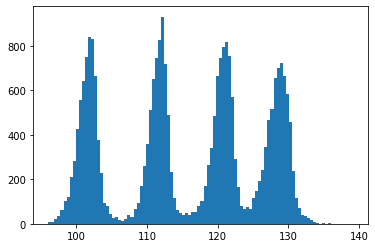

6.238080109865929


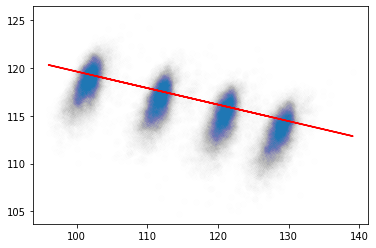

In [ ]:
new_result_list = []

tmp_result_list = np.array(result_list).copy()
for i in tqdm(range(len(tmp_result_list))):
    if i in idx_1:
        img = tmp_result_list[i]
        new_result_list.append(img)

    elif i in idx_2:
        img = tmp_result_list[i]
        img[img < 140] += 8
        new_result_list.append(img)

    elif i in idx_3:
        img = tmp_result_list[i]
        img[img < 159] += 13
        new_result_list.append(img)

    else:
        img = tmp_result_list[i]
        img[img < 160] += 17
        new_result_list.append(img)        

test_vae_depth_mean = []
for i in range(len(result_list)):
    test_vae_depth_mean.append(np.mean(new_result_list[i]))
plt.hist(test_vae_depth_mean, bins = 100)
plt.show()
y_pred = linear_Regression.predict(np.array(test_vae_depth_mean).reshape(-1, 1))
mse = mean_squared_error(test_sem_mean, y_pred)
print(mse)
plt.scatter(test_vae_depth_mean, test_sem_mean, alpha = 0.005)
plt.plot(np.array(test_vae_depth_mean), y_pred, color = 'red')
plt.show()

os.makedirs('/submission', exist_ok=True)
os.chdir("/submission")
sub_imgs = []
for path, pred_img in zip(result_name_list, result_list):
    cv2.imwrite(path, pred_img)
    sub_imgs.append(path)
submission = zipfile.ZipFile("/" + "1113" + "_submission.zip", 'w')
for path in sub_imgs:
    submission.write(path)
submission.close()